## **Medical Report Summarisation using Medical Knowledge**

### **References**

**Main Reference**
- Radiology report generation with medical knowledge and multilevel image-report alignment: A new method and its verification
https://www.sciencedirect.com/science/article/pii/S0933365723002282



## **Data Collection**

### **Collect Datasets**

In [5]:
'''Libraries Installation and Import'''

# installling necessary libraries
!pip -q install --user requests numpy pandas matplotlib tqdm Pillow opencv-python nltk pyspellchecker torch torchvision torchaudio transformers scikit-learn sentence-transformers

# importing required libraries
import os
import re
import requests
import tarfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tqdm import tqdm
from PIL import Image
import cv2

import nltk
from nltk.corpus import stopwords
from spellchecker import SpellChecker

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn.functional as F

import transformers
from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [6]:
'''Setting Paths'''

# project directory
# from google.colab import drive
# drive.mount('/content/drive')
# project_directory = '/content/drive/Othercomputers/My Laptop/CS550_ASMT_MRSMK/datasets'
# project_directory = '/content/drive/MyDrive/Academics/CS550 Machine Learning/CS550 ASMT MRSMK/datasets'

project_directory = "./datasets"
dataset = 'iu_xray/'
iu_xray_dataset = os.path.join(project_directory, dataset)


# input directory
input_directory = os.path.join(iu_xray_dataset, "input")

images_dir = os.path.join(input_directory, "images")
reports_dir = os.path.join(input_directory, "reports")
iu_xray_images = images_dir
iu_xray_reports = os.path.join(reports_dir, 'ecgen-radiology')


# output directory 
output_directory = os.path.join(iu_xray_dataset, "output")

In [7]:
'''Setup - Generalized'''

# setup to download the IU X-Ray Dataset
images_url = "https://openi.nlm.nih.gov/imgs/collections/NLMCXR_png.tgz"
reports_url = "https://openi.nlm.nih.gov/imgs/collections/NLMCXR_reports.tgz"


# function to check the file size of a given URL
def get_file_size(url):
    response = requests.head(url)
    size_in_bytes = int(response.headers.get('Content-Length', 0))
    size_in_mb = size_in_bytes / (1024 * 1024)
    return size_in_mb


# function to download and extract from a given url to a given directory
def download_and_extract(url, save_dir):
    file_name = url.split('/')[-1]
    file_path = os.path.join(save_dir, file_name)

    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('Content-Length', 0))
    downloaded_size = 0

    with open(file_path, 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
                downloaded_size += len(chunk)
                percent_complete = (downloaded_size / total_size) * 100
                print(f"Downloaded {downloaded_size / (1024*1024):.2f} MB out of {total_size / (1024*1024):.2f} MB: {percent_complete:.2f}% complete")

    print("\nDownload complete!")

    with tarfile.open(file_path, 'r:gz') as tar:
        members = tar.getmembers()
        total_files = len(members)

        for idx, member in enumerate(members, start=1):
            tar.extract(member, path=save_dir)
            print(f"Extracting File {idx} out of {total_files}: {member.name}")

    os.remove(file_path)


# downloading  IU X-Ray dataset
if not os.path.exists(images_dir):
    images_size = get_file_size(images_url)
    print(f"Downloading {images_url} to: {images_dir} ({images_size:.2f} MB)")
    os.makedirs(images_dir, exist_ok=True)
    download_and_extract(images_url, images_dir)
    print(f"Downloaded {images_url} to: {images_dir}")
else:
    print(f"{images_url} already exists at: {images_dir}")

if not os.path.exists(reports_dir):
    reports_size = get_file_size(reports_url)
    print(f"Downloading {reports_url} to: {reports_dir} ({reports_size:.2f} MB)")
    os.makedirs(reports_dir, exist_ok=True)
    download_and_extract(reports_url, reports_dir)
    print(f"Downloaded {reports_url} to: {reports_dir}")
else:
    print(f"{reports_url} already exists at: {reports_dir}")

https://openi.nlm.nih.gov/imgs/collections/NLMCXR_png.tgz already exists at: ./datasets\iu_xray/input\images
https://openi.nlm.nih.gov/imgs/collections/NLMCXR_reports.tgz already exists at: ./datasets\iu_xray/input\reports


In [8]:
'''Exploring the IU X-Ray Dataset Contents'''

# displaying directory and subdirectory contents
print("\nPath: ", iu_xray_images)
print(f"Directory Contents: {len(os.listdir(iu_xray_images))} Images")

print("\nPath: ", iu_xray_reports)
print(f"Directory Contents: {len(os.listdir(iu_xray_reports))} Reports")


Path:  ./datasets\iu_xray/input\images
Directory Contents: 7472 Images

Path:  ./datasets\iu_xray/input\reports\ecgen-radiology
Directory Contents: 3955 Reports


In [9]:
'''Processing Textual Data from each .xml Report File and Storing it in a .csv File'''

# function to iterate through all .xml report files and storing them in a dataframe
def save_images_df():
    data = []
    cnt = 0
    for file in os.listdir(iu_xray_reports):
        if file.endswith(".xml"):
            cnt += 1
            print(f"Processing .xml File {cnt} out of {len(os.listdir(iu_xray_reports))}: {file}")

            file_path = os.path.join(iu_xray_reports, file)
            try:
                tree = ET.parse(file_path)
                root = tree.getroot()

                pmc_id = root.find('.//pmcId').attrib.get('id')

                comparison = indication = findings = impression = None

                for abstract in root.findall('.//AbstractText'):
                    if abstract.attrib.get('Label') == 'COMPARISON':
                        comparison = abstract.text
                    elif abstract.attrib.get('Label') == 'INDICATION':
                        indication = abstract.text
                    elif abstract.attrib.get('Label') == 'FINDINGS':
                        findings = abstract.text
                    elif abstract.attrib.get('Label') == 'IMPRESSION':
                        impression = abstract.text

                for parent_image in root.findall('parentImage'):
                    image_file = parent_image.attrib['id'] + ".png"
                    image_path = os.path.join(iu_xray_images, image_file)
                    image = cv2.imread(image_path)

                    if image is not None:
                        height, width, channels = image.shape
                        caption = parent_image.find('caption').text if parent_image.find('caption') is not None else None
                        data.append([pmc_id, image_file, caption, comparison, indication, findings, impression, height, width])
                    else:
                        print(f"Warning: Unable to read image {image_path}")

            except Exception as e:
                print(f"Error processing file {file}: {e}")

    return data


# creating a dataframe and saving it as .csv
iu_xray_images_df_path = os.path.join(output_directory, 'iu_xray_images_df.csv')
if not os.path.exists(iu_xray_images_df_path):
    data = save_images_df()
    columns = ['pmc_id', 'image_filename', 'caption', 'comparison', 'indication', 'findings', 'impression', 'height', 'width']
    iu_xray_images_df = pd.DataFrame(data, columns=columns)
    iu_xray_images_df.to_csv(iu_xray_images_df_path, index=False)
    print(f"Dataframe saved to {iu_xray_images_df_path}")
else:
    print(f"Dataframe already exists at {iu_xray_images_df_path}")
    iu_xray_images_df = pd.read_csv(iu_xray_images_df_path)


# displaying the stored dataframe
print("\n\nDataframe Shape:", iu_xray_images_df.shape)

print("\n\nDataframe Information:\n")
display(iu_xray_images_df.info())

print("\n\nDisplaying Dataframe:\n")
display(iu_xray_images_df.head())

Dataframe already exists at ./datasets\iu_xray/output\iu_xray_images_df.csv


Dataframe Shape: (7470, 9)


Dataframe Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7470 entries, 0 to 7469
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   pmc_id          7470 non-null   int64 
 1   image_filename  7470 non-null   object
 2   caption         7468 non-null   object
 3   comparison      5210 non-null   object
 4   indication      7311 non-null   object
 5   findings        6473 non-null   object
 6   impression      7418 non-null   object
 7   height          7470 non-null   int64 
 8   width           7470 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 525.4+ KB


None



Displaying Dataframe:



,pmc_id,image_filename,caption,comparison,indication,findings,impression,height,width
0,1,CXR1_1_IM-0001-3001.png,Xray Chest PA and Lateral,None.,Positive TB test,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,624,512
1,1,CXR1_1_IM-0001-4001.png,Xray Chest PA and Lateral,None.,Positive TB test,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,420,512
2,10,CXR10_IM-0002-1001.png,PA and lateral chest x-XXXX XXXX.,Chest radiographs XXXX.,"XXXX-year-old male, chest pain.",The cardiomediastinal silhouette is within nor...,No acute cardiopulmonary process.,624,512
3,10,CXR10_IM-0002-2001.png,PA and lateral chest x-XXXX XXXX.,Chest radiographs XXXX.,"XXXX-year-old male, chest pain.",The cardiomediastinal silhouette is within nor...,No acute cardiopulmonary process.,420,512
4,100,CXR100_IM-0002-1001.png,"CHEST 2V FRONTAL/LATERAL XXXX, XXXX XXXX PM",None.,NaN,Both lungs are clear and expanded. Heart and m...,No active disease.,420,512


In [10]:
'''Processing Textual Data from each .xml Report File and Storing it in a .csv File'''

# function to iterate through all .xml report files and storing them in a dataframe
def save_reports_df():
    data = []
    cnt = 0
    for file in os.listdir(iu_xray_reports):
        if file.endswith(".xml"):
            cnt += 1
            print(f"Processing .xml File {cnt} out of {len(os.listdir(iu_xray_reports))}: {file}")

            file_path = os.path.join(iu_xray_reports, file)
            try:
                tree = ET.parse(file_path)
                root = tree.getroot()

                pmc_id = root.find('.//pmcId').attrib.get('id')

                comparison = indication = findings = impression = None

                for abstract in root.findall('.//AbstractText'):
                    if abstract.attrib.get('Label') == 'COMPARISON':
                        comparison = abstract.text
                    elif abstract.attrib.get('Label') == 'INDICATION':
                        indication = abstract.text
                    elif abstract.attrib.get('Label') == 'FINDINGS':
                        findings = abstract.text
                    elif abstract.attrib.get('Label') == 'IMPRESSION':
                        impression = abstract.text

                report_data = {
                    'pmc_id': pmc_id,
                    'findings': findings,
                    'impression': impression,
                    'comparison': comparison,
                    'indication': indication,
                }

                parent_images = root.findall('parentImage')
                report_data['image_count'] = len(parent_images)

                for i, parent_image in enumerate(parent_images, start=1):
                    image_file = parent_image.attrib['id'] + ".jpg"
                    caption = parent_image.find('caption').text if parent_image.find('caption') is not None else None
                    report_data[f'image_{i}'] = f"{image_file}: {caption}" if caption else image_file

                data.append(report_data)

            except Exception as e:
                print(f"Error processing file {file}: {e}")

    return data


# creating a dataframe and saving it as .csv
iu_xray_reports_df_path = os.path.join(output_directory, 'iu_xray_reports_df.csv')
if not os.path.exists(iu_xray_reports_df_path):
    data = save_reports_df()
    iu_xray_reports_df = pd.DataFrame(data)
    iu_xray_reports_df.to_csv(iu_xray_reports_df_path, index=False)
    print(f"Dataframe saved to {iu_xray_reports_df_path}")
else:
    print(f"Dataframe already exists at {iu_xray_reports_df_path}")
    iu_xray_reports_df = pd.read_csv(iu_xray_reports_df_path)


# displaying the stored dataframe
print("\n\nDataframe Shape:", iu_xray_reports_df.shape)

print("\n\nDataframe Information:\n")
display(iu_xray_reports_df.info())

print("\n\nDisplaying Dataframe:\n")
display(iu_xray_reports_df.head())

Dataframe already exists at ./datasets\iu_xray/output\iu_xray_reports_df.csv


Dataframe Shape: (3955, 11)


Dataframe Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3955 entries, 0 to 3954
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   pmc_id       3955 non-null   int64 
 1   findings     3425 non-null   object
 2   impression   3921 non-null   object
 3   comparison   2757 non-null   object
 4   indication   3865 non-null   object
 5   image_count  3955 non-null   int64 
 6   image_1      3851 non-null   object
 7   image_2      3405 non-null   object
 8   image_3      197 non-null    object
 9   image_4      16 non-null     object
 10  image_5      1 non-null      object
dtypes: int64(2), object(9)
memory usage: 340.0+ KB


None



Displaying Dataframe:



,pmc_id,findings,impression,comparison,indication,image_count,image_1,image_2,image_3,image_4,image_5
0,1,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,None.,Positive TB test,2,CXR1_1_IM-0001-3001.jpg: Xray Chest PA and Lat...,CXR1_1_IM-0001-4001.jpg: Xray Chest PA and Lat...,NaN,NaN,NaN
1,10,The cardiomediastinal silhouette is within nor...,No acute cardiopulmonary process.,Chest radiographs XXXX.,"XXXX-year-old male, chest pain.",2,CXR10_IM-0002-1001.jpg: PA and lateral chest x...,CXR10_IM-0002-2001.jpg: PA and lateral chest x...,NaN,NaN,NaN
2,100,Both lungs are clear and expanded. Heart and m...,No active disease.,None.,NaN,2,CXR100_IM-0002-1001.jpg: CHEST 2V FRONTAL/LAT...,CXR100_IM-0002-2001.jpg: CHEST 2V FRONTAL/LAT...,NaN,NaN,NaN
3,1000,There is XXXX increased opacity within the rig...,1. Increased opacity in the right upper lobe w...,XXXX PA and lateral chest radiographs,"XXXX-year-old male, XXXX.",3,CXR1000_IM-0003-1001.jpg: PA and lateral chest...,CXR1000_IM-0003-2001.jpg: PA and lateral chest...,CXR1000_IM-0003-3001.jpg: PA and lateral chest...,NaN,NaN
4,1001,Interstitial markings are diffusely prominent ...,Diffuse fibrosis. No visible focal acute disease.,NaN,"dyspnea, subjective fevers, arthritis, immigra...",2,CXR1001_IM-0004-1001.jpg: CHEST 2V FRONTAL/LAT...,CXR1001_IM-0004-1002.jpg: CHEST 2V FRONTAL/LAT...,NaN,NaN,NaN


In [11]:
'''Displaying the Number of Images per Report'''

# displaying the distribution of number of images per report
reports_count = iu_xray_reports_df['image_count'].value_counts().rename_axis('images_qty').reset_index(name='reports_count')
print("\n\nNumber of Images per Report:\n")
display(reports_count)



Number of Images per Report:



,images_qty,reports_count
0,2,3208
1,1,446
2,3,181
3,0,104
4,4,15
5,5,1


## **Data Preprocessing**

### **Preprocess Images**

In [12]:
'''Preprocessing Images - Resizing, Tensor Conversion and Normalization'''

# function to preprocess and save images
def preprocess_images(input_dir, output_dir):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    os.makedirs(output_dir, exist_ok=True)

    cnt = 0
    for filename in os.listdir(input_dir):
        if filename.endswith('.png'):
            cnt += 1
            print(f"Preprocessing File {cnt} out of {len(os.listdir(input_dir))}: {filename}")

            image_path = os.path.join(input_dir, filename)
            image = Image.open(image_path).convert('RGB')
            processed_image = preprocess(image)

            processed_image_path = os.path.join(output_dir, filename)

            processed_image_pil = transforms.ToPILImage()(processed_image)
            processed_image_pil.save(processed_image_path)


# preprocessing images
iu_xray_images_preprocessed = os.path.join(output_directory, 'images_preprocessed')
if not os.path.exists(iu_xray_images_preprocessed):
    print(f"Preprocessing Images to: {iu_xray_images_preprocessed}")
    preprocess_images(iu_xray_images, iu_xray_images_preprocessed)
    print(f"Preprocessed Images saved to: {iu_xray_images_preprocessed}")
else:
    print(f"Preprocessed Images already exist at: {iu_xray_images_preprocessed}")

Preprocessed Images already exist at: ./datasets\iu_xray/output\images_preprocessed


### **Preprocess Text**

In [13]:
'''Preprocessing Text - Lowercasing, Decontracting, Punctuation Removal, Number Removal, Two-Letter Word Removal, Stop Word Removal, Spell Checking, Extra Space Removal'''

# download nltk resources and initialize spell checker
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
spell = SpellChecker()


# function to convert text to lowercase
def lowercase(text):
    return text.lower() if isinstance(text, str) else text


# function to decontract words
def decontracted(text):
    if not isinstance(text, str):
        return text
    contractions = {
        "won't": "will not", "can't": "can not", "couldn't": "could not",
        "shouldn't": "should not", "wouldn't": "would not", "n't": " not",
        "'re": " are", "'s": " is", "'d": " would", "'ll": " will",
        "'t": " not", "'ve": " have", "'m": " am"
    }
    for contraction, full_form in contractions.items():
        text = text.replace(contraction, full_form)
    return text


# function to remove punctuations
def rem_punctuations(text):
    return re.sub(r'[^\w\s]', ' ', text) if isinstance(text, str) else text


# function to remove numbers
def rem_numbers(text):
    return re.sub(r'\d+', ' ', text) if isinstance(text, str) else text


# function to remove two-letter words except "no" and "ct"
def rem_two_letter_words(text):
    if not isinstance(text, str):
        return text
    return ' '.join(word for word in text.split() if len(word) > 2 or word in ["no", "ct"])


# function to remove stop words
def rem_stop_words(text):
    if not isinstance(text, str):
        return text
    stop_words = set(stopwords.words('english'))
    return ' '.join(word for word in text.split() if word not in stop_words)


# function to correct spelling
def correct_spelling(text):
    if not isinstance(text, str):
        return text
    corrected = []
    for word in text.split():
        corrected_word = list(spell.candidates(word))[0] if spell.candidates(word) else word
        corrected.append(corrected_word)
    return ' '.join(corrected)


# function to remove extra spaces
def rem_extra_spaces(text):
    return ' '.join(text.split()) if isinstance(text, str) else text


# function to preprocess text
def preprocess_text(data):
    preprocessed = []
    for sentence in tqdm(data.values):
        sentence = str(sentence)
        sentence = lowercase(sentence)
        sentence = decontracted(sentence)
        sentence = rem_punctuations(sentence)
        sentence = rem_numbers(sentence)
        sentence = rem_two_letter_words(sentence)
        sentence = rem_stop_words(sentence)
        sentence = correct_spelling(sentence)
        sentence = rem_extra_spaces(sentence)
        
        preprocessed.append(sentence)

    return preprocessed


# path to the preprocessed dataframe
iu_xray_reports_preprocessed_df_path = os.path.join(output_directory, 'iu_xray_reports_preprocessed_df.csv')
iu_xray_reports_preprocessed_df = iu_xray_reports_df.copy()


# preprocessing text columns in the dataframe
if not os.path.exists(iu_xray_reports_preprocessed_df_path):
    print(f"Preprocessing Text of DataFrame {iu_xray_reports_df_path} to: {iu_xray_reports_preprocessed_df_path}")
    
    preprocess_caption = True
    preprocess_comparison = True
    preprocess_indication = True
    preprocess_findings = True
    preprocess_impression = True
    
    if preprocess_caption and 'caption' in iu_xray_reports_preprocessed_df.columns:
        print("Preprocessing Column: caption")
        iu_xray_reports_preprocessed_df['caption'] = iu_xray_reports_preprocessed_df['caption'].fillna('unknown').astype(str)
        iu_xray_reports_preprocessed_df['caption'] = preprocess_text(iu_xray_reports_preprocessed_df['caption'])
        iu_xray_reports_preprocessed_df.to_csv(iu_xray_reports_preprocessed_df_path, index=False)
        print(f"Saved preprocessed 'caption' column to: {iu_xray_reports_preprocessed_df_path}")
    
    if preprocess_comparison and 'comparison' in iu_xray_reports_preprocessed_df.columns:
        print("Preprocessing Column: comparison")
        iu_xray_reports_preprocessed_df['comparison'] = iu_xray_reports_preprocessed_df['comparison'].fillna('none').astype(str)
        iu_xray_reports_preprocessed_df['comparison'] = preprocess_text(iu_xray_reports_preprocessed_df['comparison'])
        iu_xray_reports_preprocessed_df.to_csv(iu_xray_reports_preprocessed_df_path, index=False)
        print(f"Saved preprocessed 'comparison' column to: {iu_xray_reports_preprocessed_df_path}")
    
    if preprocess_indication and 'indication' in iu_xray_reports_preprocessed_df.columns:
        print("Preprocessing Column: indication")
        iu_xray_reports_preprocessed_df['indication'] = iu_xray_reports_preprocessed_df['indication'].fillna('none').astype(str)
        iu_xray_reports_preprocessed_df['indication'] = preprocess_text(iu_xray_reports_preprocessed_df['indication'])
        iu_xray_reports_preprocessed_df.to_csv(iu_xray_reports_preprocessed_df_path, index=False)
        print(f"Saved preprocessed 'indication' column to: {iu_xray_reports_preprocessed_df_path}")
    
    if preprocess_findings and 'findings' in iu_xray_reports_preprocessed_df.columns:
        print("Preprocessing Column: findings")
        iu_xray_reports_preprocessed_df['findings'] = iu_xray_reports_preprocessed_df['findings'].fillna('none').astype(str)
        iu_xray_reports_preprocessed_df['findings'] = preprocess_text(iu_xray_reports_preprocessed_df['findings'])
        iu_xray_reports_preprocessed_df.to_csv(iu_xray_reports_preprocessed_df_path, index=False)
        print(f"Saved preprocessed 'findings' column to: {iu_xray_reports_preprocessed_df_path}")
    
    if preprocess_impression and 'impression' in iu_xray_reports_preprocessed_df.columns:
        print("Preprocessing Column: impression")
        iu_xray_reports_preprocessed_df['impression'] = iu_xray_reports_preprocessed_df['impression'].fillna('none').astype(str)
        iu_xray_reports_preprocessed_df['impression'] = preprocess_text(iu_xray_reports_preprocessed_df['impression'])
        iu_xray_reports_preprocessed_df.to_csv(iu_xray_reports_preprocessed_df_path, index=False)
        print(f"Saved preprocessed 'impression' column to: {iu_xray_reports_preprocessed_df_path}")
else:
    print(f"Preprocessed Text of DataFrame {iu_xray_reports_df_path} already exists at: {iu_xray_reports_preprocessed_df_path}")
    

# displaying the preprocessed dataframe
iu_xray_reports_preprocessed_df = pd.read_csv(iu_xray_reports_preprocessed_df_path)
display(iu_xray_reports_preprocessed_df.head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preprocessed Text of DataFrame ./datasets\iu_xray/output\iu_xray_reports_df.csv already exists at: ./datasets\iu_xray/output\iu_xray_reports_preprocessed_df.csv


,pmc_id,findings,impression,comparison,indication,image_count,image_1,image_2,image_3,image_4,image_5
0,1,cardiac silhouette mediastinum size within nor...,normal chest xxxx,none,positive test,2,CXR1_1_IM-0001-3001.jpg: Xray Chest PA and Lat...,CXR1_1_IM-0001-4001.jpg: Xray Chest PA and Lat...,NaN,NaN,NaN
1,10,cardiomediastinal silhouette within normal lim...,acute cardiopulmonary process,chest radiographs xxxx,xxxx year old male chest pain,2,CXR10_IM-0002-1001.jpg: PA and lateral chest x...,CXR10_IM-0002-2001.jpg: PA and lateral chest x...,NaN,NaN,NaN
2,100,lungs clear expanded heart mediastinum normal,active disease,none,none,2,CXR100_IM-0002-1001.jpg: CHEST 2V FRONTAL/LAT...,CXR100_IM-0002-2001.jpg: CHEST 2V FRONTAL/LAT...,NaN,NaN,NaN
3,1000,xxxx increased opacity within right upper lobe...,increased opacity right upper lobe xxxx associ...,xxxx lateral chest radiographs,xxxx year old male xxxx,3,CXR1000_IM-0003-1001.jpg: PA and lateral chest...,CXR1000_IM-0003-2001.jpg: PA and lateral chest...,CXR1000_IM-0003-3001.jpg: PA and lateral chest...,NaN,NaN
4,1001,interstitial markings diffusely prominent thro...,diffuse fibrosis visible focal acute disease,none,dyspnea subjective fevers arthritis immigrant ...,2,CXR1001_IM-0004-1001.jpg: CHEST 2V FRONTAL/LAT...,CXR1001_IM-0004-1002.jpg: CHEST 2V FRONTAL/LAT...,NaN,NaN,NaN


### **Create Data Loaders**

In [14]:
'''Image Data Loaders to Supply Dataset to Model in Batches'''

# classes in dataset
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image


# function to load image data with transformation and batching
def load_preprocessed_images(image_dir, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    dataset = CustomImageDataset(image_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

In [15]:
'''Text Data Loaders to Supply Dataset to Model in Batches'''

# classes in dataset
class CustomTextDataset(Dataset):
    def __init__(self, text_list, tokenizer, max_length=512):
        self.text_list = text_list
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.text_list)

    def __getitem__(self, idx):
        text = self.text_list[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {key: tensor.squeeze(0) for key, tensor in encoding.items()}


# function to load text data with batching
def load_preprocessed_texts(text_list, tokenizer, batch_size=32, max_length=512):
    dataset = CustomTextDataset(text_list, tokenizer, max_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

## **Model Implementation**

### **Visual Extractor**

In [16]:
'''Visual Extractor to Extract Data from Image and Encode it Accordingly'''

# defining device for gpu support
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# defining the visual extractor model using ResNet101 
class VisualExtractor(nn.Module):
    def __init__(self, args):
        super(VisualExtractor, self).__init__()
        self.visual_extractor = args.visual_extractor
        weights = models.ResNet101_Weights.DEFAULT if args.visual_extractor_pretrained else None  
        model = getattr(models, self.visual_extractor)(weights=weights)
        modules = list(model.children())[:-2]  
        self.model = nn.Sequential(*modules)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_layer = nn.Linear(model.fc.in_features, 2048) 
        
    def forward(self, images):
        patch_feats = self.model(images)
        avg_feats = self.avg_pool(patch_feats).squeeze() 
        avg_feats = self.fc_layer(avg_feats)

        batch_size, feat_size, _, _ = patch_feats.shape
        patch_feats = patch_feats.view(batch_size, feat_size, -1).permute(0, 2, 1)
        
        final_embedding = torch.cat((avg_feats.unsqueeze(1), patch_feats), dim=1) 
        
        return patch_feats, avg_feats, final_embedding


# arguments for the visual extractor
class Args:
    visual_extractor = 'resnet101' 
    visual_extractor_pretrained = True


# initializing the model
args = Args()
visual_extractor = VisualExtractor(args).to(device)


# function to extract features from images
def extract_features(images_dataloader):
    all_patch_feats = []
    all_avg_feats = []
    all_final_embeddings = []

    visual_extractor.eval() 
    with torch.no_grad():
        for images in tqdm(images_dataloader):
            images = images.to(device)
            patch_feats, avg_feats, final_embedding = visual_extractor(images)
            all_patch_feats.append(patch_feats.cpu()) 
            all_avg_feats.append(avg_feats.cpu())
            all_final_embeddings.append(final_embedding.cpu())

    all_patch_feats = torch.cat(all_patch_feats, dim=0)
    all_avg_feats = torch.cat(all_avg_feats, dim=0)
    all_final_embeddings = torch.cat(all_final_embeddings, dim=0)

    return all_patch_feats, all_avg_feats, all_final_embeddings


# function to save extracted features
def save_features(file_path, features):
    print(f"Saving features to {file_path}")
    torch.save(features, file_path)


# function to lead the extracted features
def load_features(file_path):
    if os.path.exists(file_path):
        print(f"Loading features from {file_path}")
        return torch.load(file_path, weights_only=True)
    return None


# initializing paths
feature_dir = output_directory
patch_feats_file = os.path.join(output_directory, 'patch_feats.pt')
avg_feats_file = os.path.join(output_directory, 'avg_feats.pt')
image_embeddings_file = os.path.join(output_directory, 'image_embeddings.pt')
images_dataloader = load_preprocessed_images(iu_xray_images_preprocessed)


# extracting and saving the extracted features
if os.path.exists(patch_feats_file) and os.path.exists(avg_feats_file) and os.path.exists(image_embeddings_file):
    print("All features are already precomputed and will be loaded.")
    patch_feats = load_features(patch_feats_file)
    avg_feats = load_features(avg_feats_file)
    image_embeddings = load_features(image_embeddings_file)
else:
    print("Extracting features since they are not precomputed...")
    patch_feats, avg_feats, image_embeddings = extract_features(images_dataloader) 
        
    os.makedirs(feature_dir, exist_ok=True)
    save_features(patch_feats_file, patch_feats)
    save_features(avg_feats_file, avg_feats)
    save_features(image_embeddings_file, image_embeddings)


# displaying sizes of the feature dataframes
print("Patch Features Shape:", patch_feats.shape)
print("Average Features Shape:", avg_feats.shape)
print("Final Embedding Shape:", image_embeddings.shape)

All features are already precomputed and will be loaded.
Loading features from ./datasets\iu_xray/output\patch_feats.pt
Loading features from ./datasets\iu_xray/output\avg_feats.pt
Loading features from ./datasets\iu_xray/output\image_embeddings.pt
Patch Features Shape: torch.Size([7470, 49, 2048])
Average Features Shape: torch.Size([7470, 2048])
Final Embedding Shape: torch.Size([7470, 50, 2048])


Original feature shape: (7470, 2048)


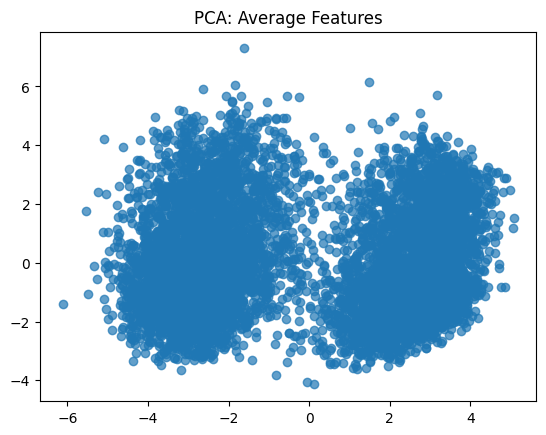

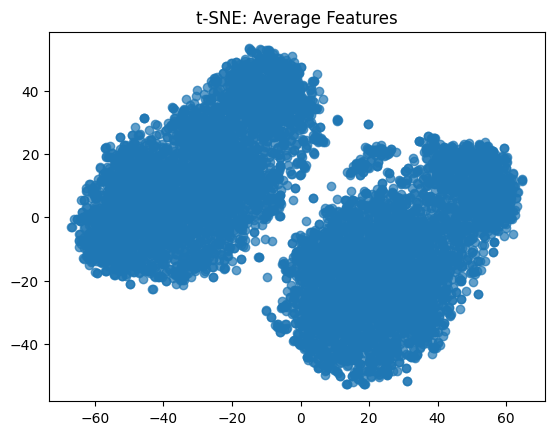

Original feature shape: (7470, 49, 2048)


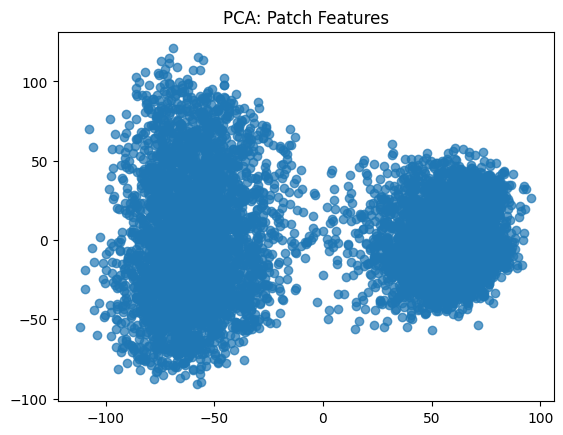

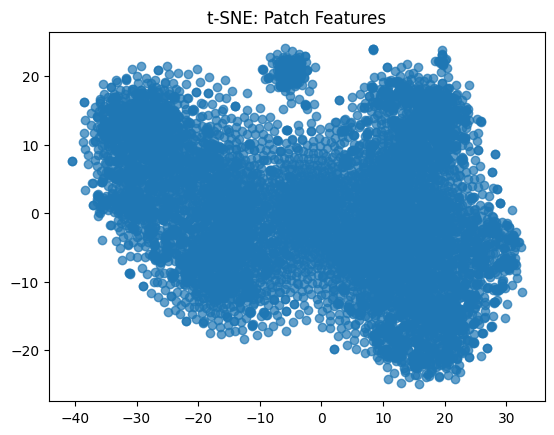

Original feature shape: (7470, 50, 2048)


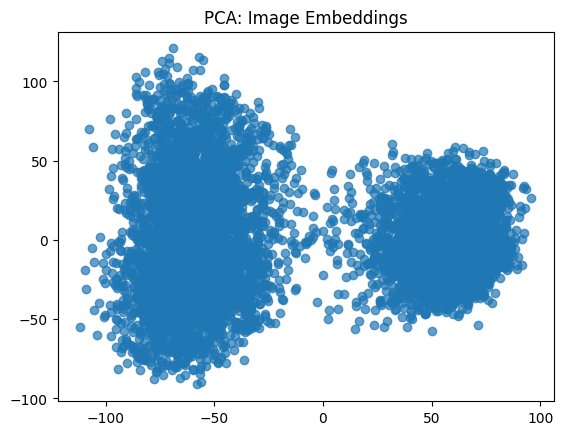

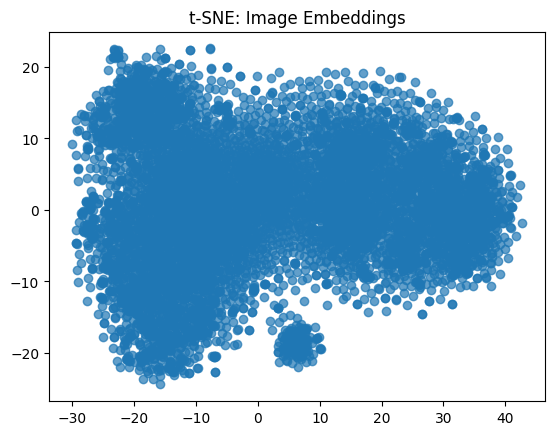

In [18]:
'''Visualizing Extracted Features using Plots'''

# function to visualize features using PCA and t-SNE, including K-Means clustering
def visualize_features(features, title):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features)

    tsne = TSNE(n_components=2)
    tsne_result = tsne.fit_transform(features)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
    plt.title(f"PCA - {title}")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")

    plt.subplot(1, 2, 2)
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.5)
    plt.title(f"t-SNE - {title}")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")

    plt.show()

    num_clusters = 3
    kmeans = KMeans(n_clusters=num_clusters)
    labels = kmeans.fit_predict(features)
    
    plt.figure(figsize=(8, 8))
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.title('t-SNE Result with K-Means Clusters')
    plt.colorbar()
    plt.show()
    plt.figure(figsize=(8, 8))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.title('PCA Result with K-Means Clusters')
    plt.colorbar()
    plt.show()


# function to visualize features using PCA and t-SNE, without clustering
def visualize_features_2(features, title):
    print(f"Original feature shape: {features.shape}")
    
    flattened_features = features.reshape(features.shape[0], -1) 
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(flattened_features)

    tsne = TSNE(n_components=2)
    tsne_result = tsne.fit_transform(flattened_features)

    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
    plt.title(f'PCA: {title}')
    plt.show()
    
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.7)
    plt.title(f't-SNE: {title}')
    plt.show()


# visualizing average features
visualize_features_2(avg_feats.numpy(), "Average Features")
visualize_features_2(patch_feats.numpy(), "Patch Features")
visualize_features_2(image_embeddings.numpy(), "Image Embeddings")

### **Text Encoder**

In [ ]:
'''Text Encoder - Text Encoder using Medical Knowledge and Sentence Encoder using Medical History'''

# defining device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# reading and preprocessing medical history reports
iu_xray_reports_preprocessed_df_path = os.path.join(output_directory, 'iu_xray_reports_preprocessed_df.csv')
medical_history = pd.read_csv(iu_xray_reports_preprocessed_df_path)["findings"].dropna().tolist()
medical_history = [str(report) for report in medical_history if isinstance(report, str) or pd.notna(report)]


# defining radiology dictionary
radiology_dictionary = {
    "pleural": ['hemithorax', 'effusion', 'pneumothorax', 'pa renchymal'],
    "lung": ['lungs', 'pulmonary', 'hilar', 'lobe', 'consolidation', 'atelectasis', 'edema', 'opacity', 'pneumonia'],
    "mediastinal": ['mediastinum', 'diaphragm', 'hemidiaphragm'],
    "cardiac": ['heart', 'cardiomegaly', 'cardiomediastinal', 'atrium', 'ventricle', 'retrocardiac'],
    "vascular": ['aorta', 'venous', 'jugular', 'aortic', 'vasculature', 'cabg'],
    "osseous": ['rib', 'sternal', 'subclavian', 'thoracic'],
    "trachea": ['endotrachea'],
    "stomach": [],
    "abdomen": [],
    "tube": ['clips'],
    "spine": ['vertebral', 'degenerative'],
    "nodule": ['mass'],
    "chest": ['small', 'enlarged', 'unchanged', 'stable', 'silhouette', 'contours', 'size', 'focal', 'mild', 'acute']
}


# loading tokenizer, bert model and sentence-bert model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
sentence_model = SentenceTransformer('all-MiniLM-L6-v2').to(device)


# function to embed text
def embed_text(text_dataloader, model):
    all_embeddings = []
    try:
        for batch in text_dataloader:
            if isinstance(batch, str):
                inputs = tokenizer([batch], return_tensors="pt", padding=True, truncation=True).to(device)
            elif isinstance(batch, list):
                inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(device)
            else:
                raise ValueError("Batch must be of type str or List[str]")

            outputs = model(**inputs)
            embeddings = outputs.last_hidden_state.mean(dim=1)
            all_embeddings.append(embeddings)

        if all_embeddings:  # Check if any embeddings were collected
            return torch.cat(all_embeddings, dim=0)
        else:
            # Check the type of model to return an empty tensor of appropriate size
            if isinstance(model, SentenceTransformer):
                # Use the output dimension of the sentence model
                return torch.empty(0, model.get_sentence_embedding_dimension()).to(device)
            else:
                # Fallback for other models, like BERT
                return torch.empty(0, model.config.hidden_size).to(device)

    except Exception as e:
        print(f"Error in embedding: {e}")
        # Check the type of model to return an empty tensor of appropriate size
        if isinstance(model, SentenceTransformer):
            return torch.empty(0, model.get_sentence_embedding_dimension()).to(device)
        else:
            return torch.empty(0, model.config.hidden_size).to(device)


# embedding dictionary and reports using bert, and historical medical reports using sentence transformer
medical_dictionary_dataloader = load_preprocessed_texts(radiology_dictionary["chest"], tokenizer
                                                       )
dictionary_embeddings = embed_text(medical_dictionary_dataloader, bert_model)

medical_history_dataloader = load_preprocessed_texts(medical_history, tokenizer)
report_embeddings = embed_text(medical_history_dataloader, bert_model)
historical_embeddings = embed_text(medical_history_dataloader, sentence_model)


# calculating cosine similarities
similarities = torch.mm(report_embeddings, dictionary_embeddings.t())

print(similarities.shape)


# finding top-k relevant entries
# '''k = 5
# top_k_indices = similarities.topk(k=k, dim=1).indices


# # preparing relevant entries based on indices
# relevant_entries = []
# for row in top_k_indices:
#     relevant_entries.append([list(radiology_dictionary.keys())[idx] for idx in row])


# # printing relevant entries for each report
# for i, entries in enumerate(relevant_entries):
#     print(f"Report {i + 1}: Relevant Entries: {entries}")

# # saving dictionary embeddings
# embeddings_file_path = os.path.join(output_directory, 'dictionary_embeddings.pt')
# if not os.path.exists(embeddings_file_path):
#     torch.save(dictionary_embeddings.cpu(), embeddings_file_path)
#     print(f"Dictionary embeddings saved to {embeddings_file_path}")


# # displaying shape of dictionary embeddings and historical embeddings
# print(f"Dictionary Embeddings Shape: {dictionary_embeddings.shape}")
# print(f"Historical Embeddings Shape: {historical_embeddings.shape}")
# '''

### **Multilevel Alignment**

In [ ]:
'''Image Embeddings Processing - Loading, Normalizing, Flattening, and Computing Cosine Similarity with Dictionary Embeddings'''

# loading image embeddings
image_embeddings_path = os.path.join(output_directory, 'final_embeddings.pt')
image_embeddings = torch.load(image_embeddings_path).to(device)


# fine-grained alignment using cosine similarity
def compute_cosine_similarity(text_embeddings, image_embeddings):
    text_embeddings_normalized = F.normalize(text_embeddings, p=2, dim=1)
    image_embeddings_normalized = F.normalize(image_embeddings, p=2, dim=1)
    cosine_sim = torch.mm(text_embeddings_normalized, image_embeddings_normalized.t())
    return cosine_sim


# computing cosine similarity
similarity_matrix = compute_cosine_similarity(dictionary_embeddings, image_embeddings)


# printing shapes for verification
image_embeddings_flattened = image_embeddings.mean(dim=1)
print(f"Image Embeddings Shape: {image_embeddings.shape}")
print(f"Flattened Image Embeddings Shape: {image_embeddings_flattened.shape}")
print(f"Similarity Matrix Shape: {similarity_matrix.shape}")

### **Report Generator**

### **Complete Model**

## **Training**

### **Training**

## **Testing**

### **Testing**